# DCGAN Enhancement Experiments
## Architecture Modifications & Hyperparameter Tuning

### Component 1: Layer Modifications (10 marks)
- Deeper networks (more layers)
- Wider networks (more feature maps)
- Residual connections
- Self-attention mechanism
- Different activation functions

### Component 2: Hyperparameter Tuning (10 marks)
- Learning rates: [0.0001, 0.0002, 0.0005, 0.001]
- Batch sizes: [32, 64, 128]
- Latent dimensions: [32, 64, 100, 128]
- Beta parameters optimization
- Optimizer comparison

### Metrics:
- Generator & Discriminator Losses
- Training Time
- Image Quality Visual Assessment

In [21]:
# Import Libraries
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import kagglehub
import time
import json
from collections import defaultdict

# Set random seed
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda:0


In [22]:
from PIL import Image, ImageEnhance
import io

# Load the dataset from parquet
splits = {'train': 'data/train-00000-of-00001-fa0b6bb53e3b3d16.parquet', 
          'validation': 'data/validation-00000-of-00001-49f45a5ed0b4ad18.parquet', 
          'test': 'data/test-00000-of-00001-48d445de0e368b7c.parquet'}

df = pd.read_parquet("hf://datasets/James-A/Minecraft-16x-Dataset/" + splits["train"])

print("DataFrame shape (before filtering):", df.shape)
print("DataFrame columns:", df.columns.tolist())

DataFrame shape (before filtering): (1366, 19)
DataFrame columns: ['image', 'texture_name', 'texture_size', 'type', 'primary_colors', 'secondary_colors', 'pattern_description', 'texture_style', 'lighting_reflection', 'symmetry', 'tileable_direction', 'visual_complexity', 'illumination_effects', 'usage_context', 'functionality', 'related_items_blocks', 'mimicry_biome_association', 'special_effects_in_game_functionality', 'overall_texture_description']


In [23]:
def extract_types_from_row(type_str):
    """Extract individual types from a row's type column"""
    if pd.isna(type_str):
        return []
    
    parts = type_str.split(' - ')
    if len(parts) > 1:
        types_part = parts[1]
        individual_types = [t.strip() for t in types_part.split(',')]
        return individual_types
    return []

def get_primary_label(type_str, priority_types):
    """
    Get the primary label based on priority types.
    Returns the first matching type from priority_types, or None if no match.
    """
    types = extract_types_from_row(type_str)
    
    # Check each priority type in order
    for priority_type in priority_types:
        if priority_type in types:
            return priority_type
    
    return None

filter_types = [
    'Utility',
    'Decorative',
    'Wood',
    'Plant',
    'Stone',
    'Potion',
    'Food',
    'Tool',
    'Spawn Egg',
    'Light Source'
]

In [24]:
# Apply labeling
df['label'] = df['type'].apply(lambda x: get_primary_label(x, filter_types))

# Check results before filtering
print("Label distribution before filtering:")
print(df['label'].value_counts(dropna=False))
print(f"\nRows with no matching label (will be dropped): {df['label'].isna().sum()}")

# Drop rows that don't have any of the top 10 types
df_filtered = df[df['label'].notna()].copy()

print(f"\nOriginal dataset size: {len(df)}")
print(f"Filtered dataset size: {len(df_filtered)}")
print(f"Rows dropped: {len(df) - len(df_filtered)}")

Label distribution before filtering:
label
Utility       378
None          329
Decorative    211
Plant         110
Stone          86
Potion         62
Food           50
Wood           49
Spawn Egg      46
Tool           45
Name: count, dtype: int64

Rows with no matching label (will be dropped): 329

Original dataset size: 1366
Filtered dataset size: 1037
Rows dropped: 329


In [25]:
print("\nFinal label distribution:")
print(df_filtered['label'].value_counts())

# Create numeric labels for training (0-9)
label_to_idx = {label: idx for idx, label in enumerate(filter_types)}
df_filtered['label_idx'] = df_filtered['label'].map(label_to_idx)

print("\nLabel to index mapping:")
for label, idx in label_to_idx.items():
    count = (df_filtered['label'] == label).sum()
    print(f"{idx}: {label} ({count} samples)")

images = df_filtered['image'].tolist()
labels = df_filtered['label_idx'].values

print(f"\nFinal number of images: {len(images)}")
print(f"Labels shape: {labels.shape}")
print(f"Unique labels: {np.unique(labels)}")


Final label distribution:
label
Utility       378
Decorative    211
Plant         110
Stone          86
Potion         62
Food           50
Wood           49
Spawn Egg      46
Tool           45
Name: count, dtype: int64

Label to index mapping:
0: Utility (378 samples)
1: Decorative (211 samples)
2: Wood (49 samples)
3: Plant (110 samples)
4: Stone (86 samples)
5: Potion (62 samples)
6: Food (50 samples)
7: Tool (45 samples)
8: Spawn Egg (46 samples)
9: Light Source (0 samples)

Final number of images: 1037
Labels shape: (1037,)
Unique labels: [0 1 2 3 4 5 6 7 8]


In [26]:
import torchvision.transforms as transforms

def augment_image(img, apply_augmentation_prob=0.6):
    """
    Apply random augmentations to increase dataset variety
    apply_augmentation_prob: probability of applying ANY augmentation (default 0.9 = 90% chance)
    """
    # Skip augmentation entirely with some probability
    if np.random.rand() > apply_augmentation_prob:
        return img  # Return original image
    
    # Random horizontal flip (50% chance)
    if np.random.rand() > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Random vertical flip (50% chance)
    if np.random.rand() > 0.5:
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
    
    # Random 90-degree rotations (75% chance)
    if np.random.rand() > 0.25:
        rotation = np.random.choice([0, 90, 180, 270])
        if rotation > 0:
            img = img.rotate(rotation)
    
    # Random brightness adjustment (60% chance)
    if np.random.rand() > 0.4:
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(np.random.uniform(0.8, 1.2))
    
    # Random contrast adjustment (60% chance)
    if np.random.rand() > 0.4:
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(np.random.uniform(0.85, 1.15))
    
    return img

# Usage in your loop:
num_augmentations = 3

In [27]:
# Define target size
target_size = (16, 16)

# Process images: resize, convert to RGB
data_list = []
labels_list = []

augment = True

for img_data in images:
    # If image is stored as bytes, convert to PIL Image
    if isinstance(img_data, dict) and 'bytes' in img_data:
        img = Image.open(io.BytesIO(img_data['bytes']))
    elif isinstance(img_data, bytes):
        img = Image.open(io.BytesIO(img_data))
    else:
        img = img_data  # Already a PIL Image
    
    # Resize if needed
    if img.size != target_size:
        img = img.resize(target_size, Image.NEAREST)
    
    # Convert RGBA to RGB (handle transparency)
    if img.mode == 'RGBA':
        background = Image.new('RGB', img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        img = background
    elif img.mode != 'RGB':
        img = img.convert('RGB')

    data_list.append(np.array(img))
    labels_list.append(labels[idx])

    if augment:
        for _ in range(num_augmentations - 1):
            aug_img = augment_image(img.copy())
            data_list.append(np.array(aug_img))
            labels_list.append(labels[idx])

# Convert to numpy array
data = np.array(data_list)
labels = np.array(labels_list) 
print("Shape: ", data.shape)

Shape:  (3111, 16, 16, 3)


c:\Users\ASUS\torch-gpu\.venv\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [28]:
# Prepare tensors
images_tensor = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Normalize to [-1, 1]
if images_tensor.max() > 1.0:
    images_tensor = images_tensor / 255.0
images_tensor = images_tensor * 2.0 - 1.0

print(f"Data shape: {images_tensor.shape}")
print(f"Range: [{images_tensor.min():.2f}, {images_tensor.max():.2f}]")

Data shape: torch.Size([3111, 3, 16, 16])
Range: [-1.00, 1.00]


In [29]:
# Helper Functions
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def create_loader(images, labels, batch_size, workers=2):
    dataset = TensorDataset(images, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, 
                     num_workers=workers, drop_last=True)

def plot_comparison(results_dict, title):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    for name, res in results_dict.items():
        plt.plot(res['G_losses'], label=name, alpha=0.7)
    plt.xlabel("Iterations")
    plt.ylabel("Generator Loss")
    plt.title("Generator Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    for name, res in results_dict.items():
        plt.plot(res['D_losses'], label=name, alpha=0.7)
    plt.xlabel("Iterations")
    plt.ylabel("Discriminator Loss")
    plt.title("Discriminator Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("✓ Helper functions loaded")

✓ Helper functions loaded


## COMPONENT 1: Architecture Modifications

In [30]:
# Baseline Architecture
class BaselineGenerator(nn.Module):
    def __init__(self, z_dim=64, ngf=32, nc=3):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=z_dim, 
                out_channels=ngf*8, 
                kernel_size=4, 
                stride=1, 
                padding=0, 
                bias=False
            ),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=ngf*8, 
                out_channels=ngf*4, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                in_channels=ngf*4,
                out_channels=nc,
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

class BaselineDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=32):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

print("✓ Baseline architecture")

✓ Baseline architecture


In [31]:
# Architecture 1: Deeper Network
class DeeperGenerator(nn.Module):
    def __init__(self, z_dim=64, ngf=32, nc=3):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*16, 2, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*16, ngf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

class DeeperDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=32):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*4, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

print("✓ Deeper architecture")

✓ Deeper architecture


In [32]:
# Architecture 2: Wider Network
class WiderGenerator(nn.Module):
    def __init__(self, z_dim=64, ngf=64, nc=3):  # ngf doubled
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

class WiderDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):  # ndf doubled
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

print("✓ Wider architecture")

✓ Wider architecture


In [33]:
# Architecture 3: Residual Connections
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(True),
            nn.Conv2d(channels, channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(channels)
        )
    def forward(self, x):
        return x + self.block(x)

class ResidualGenerator(nn.Module):
    def __init__(self, z_dim=64, ngf=32, nc=3):
        super().__init__()
        self.initial = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True)
        )
        self.res_blocks = nn.Sequential(ResBlock(ngf*8), ResBlock(ngf*8))
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        return self.upsample(x)

print("✓ Residual architecture")

✓ Residual architecture


In [34]:
# Training Function with Image Display
def train_gan(netG, netD, loader, config, num_epochs, name="Experiment"):
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, config['z_dim'], 1, 1, device=device)
    
    optimizerD = optim.Adam(netD.parameters(), lr=config['lrD'], 
                           betas=(config['beta1'], config['beta2']))
    optimizerG = optim.Adam(netG.parameters(), lr=config['lrG'], 
                           betas=(config['beta1'], config['beta2']))
    
    G_losses, D_losses, img_list = [], [], []
    start_time = time.time()
    
    print(f"\n{'='*60}\nTraining: {name}\n{'='*60}")
    
    for epoch in range(num_epochs):
        for i, data in enumerate(loader):
            # Update Discriminator
            netD.zero_grad()
            real = data[0].to(device)
            b_size = real.size(0)
            label = torch.full((b_size,), 1.0, dtype=torch.float, device=device)
            
            output = netD(real).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            
            noise = torch.randn(b_size, config['z_dim'], 1, 1, device=device)
            fake = netG(noise)
            label.fill_(0.0)
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
            
            # Update Generator
            netG.zero_grad()
            label.fill_(1.0)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()
            
            G_losses.append(errG.item())
            D_losses.append(errD.item())
        
        print(f"Epoch [{epoch+1}/{num_epochs}] G: {np.mean(G_losses[-len(loader):]):.4f} D: {np.mean(D_losses[-len(loader):]):.4f}")
    
    # Generate final images
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_grid = vutils.make_grid(fake, padding=2, normalize=True, nrow=8)
    img_list.append(img_grid)
    
    # Display generated image for this experiment
    plt.figure(figsize=(7, 7))
    plt.axis("off")
    plt.title(f"Fake Images - {name}", fontsize=16, fontweight='bold')
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
    plt.tight_layout()
    plt.show()
    
    return {
        'G_losses': G_losses,
        'D_losses': D_losses,
        'img_list': img_list,
        'time': time.time() - start_time,
        'name': name
    }

print("✓ Training function ready")

✓ Training function ready


Dataset ready: 48 batches

REAL IMAGES FROM DATASET


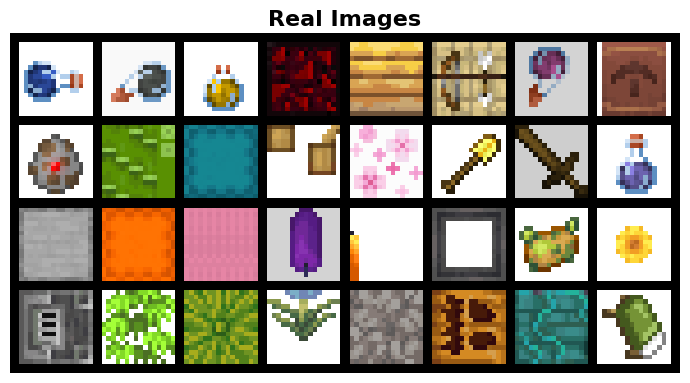

In [35]:
# Configuration
config = {
    'batch_size': 64,
    'z_dim': 64,
    'lrG': 0.0002,
    'lrD': 0.0002,
    'beta1': 0.5,
    'beta2': 0.999,
    'num_epochs': 100
}

arch_results = {}
loader = create_loader(images_tensor, labels_tensor, config['batch_size'])
print(f"Dataset ready: {len(loader)} batches")

# Display Real Images FIRST
print("\n" + "="*70)
print("REAL IMAGES FROM DATASET")
print("="*70)
real_batch = next(iter(loader))
real_images = real_batch[0][:32]  # Take first 32 images

plt.figure(figsize=(7, 7))
plt.axis("off")
plt.title("Real Images", fontsize=16, fontweight='bold')
grid = vutils.make_grid(real_images, nrow=8, padding=2, normalize=True)
plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
plt.tight_layout()


🔬 EXPERIMENT 1: Baseline

Training: Baseline
Epoch [1/100] G: 0.6533 D: 1.5577
Epoch [2/100] G: 1.1590 D: 1.1115
Epoch [3/100] G: 0.9929 D: 1.2002
Epoch [4/100] G: 0.8477 D: 1.2877
Epoch [5/100] G: 0.7544 D: 1.3533
Epoch [6/100] G: 0.7365 D: 1.3352
Epoch [7/100] G: 0.7529 D: 1.3363
Epoch [8/100] G: 0.7686 D: 1.3264
Epoch [9/100] G: 0.8347 D: 1.2773
Epoch [10/100] G: 0.8688 D: 1.2483
Epoch [11/100] G: 0.8758 D: 1.2145
Epoch [12/100] G: 0.8826 D: 1.1805
Epoch [13/100] G: 0.9072 D: 1.1676
Epoch [14/100] G: 0.9555 D: 1.1666
Epoch [15/100] G: 0.9944 D: 1.1645
Epoch [16/100] G: 0.9993 D: 1.1184
Epoch [17/100] G: 0.9757 D: 1.1812
Epoch [18/100] G: 0.9346 D: 1.2262
Epoch [19/100] G: 0.9311 D: 1.2388
Epoch [20/100] G: 0.8884 D: 1.2582
Epoch [21/100] G: 0.8649 D: 1.2739
Epoch [22/100] G: 0.8690 D: 1.2604
Epoch [23/100] G: 0.8875 D: 1.2373
Epoch [24/100] G: 0.9193 D: 1.2407
Epoch [25/100] G: 0.9281 D: 1.2244
Epoch [26/100] G: 0.9326 D: 1.2230
Epoch [27/100] G: 0.9241 D: 1.2311
Epoch [28/100] G: 

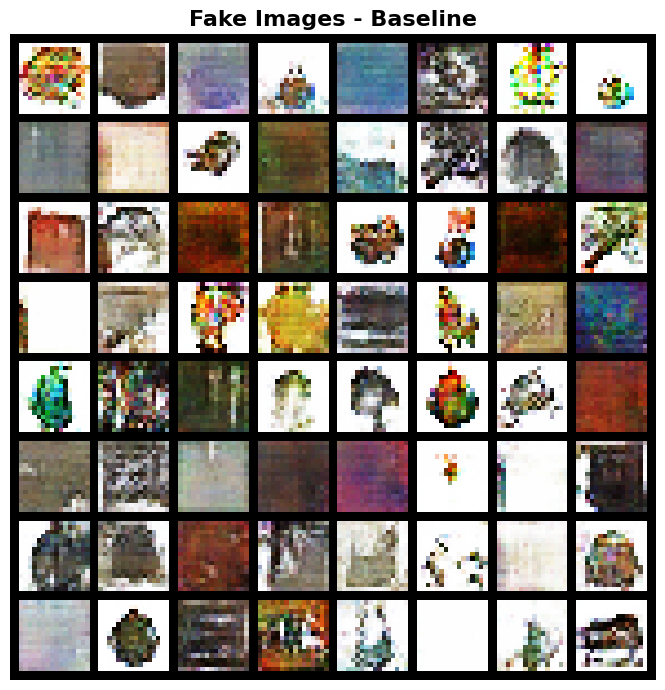

In [36]:
# Experiment 1: Baseline
print("\n🔬 EXPERIMENT 1: Baseline")
netG = BaselineGenerator(config['z_dim'], 32, 3).to(device)
netD = BaselineDiscriminator(3, 32).to(device)
netG.apply(weights_init)
netD.apply(weights_init)
arch_results['Baseline'] = train_gan(netG, netD, loader, config, config['num_epochs'], "Baseline")


🔬 EXPERIMENT 2: Deeper Network

Training: Deeper


Epoch [1/100] G: 1.3246 D: 1.1298
Epoch [2/100] G: 1.7728 D: 0.8735
Epoch [3/100] G: 0.9985 D: 1.3104
Epoch [4/100] G: 1.1935 D: 1.0941
Epoch [5/100] G: 1.0531 D: 1.2453
Epoch [6/100] G: 0.8232 D: 1.3580
Epoch [7/100] G: 0.8794 D: 1.3219
Epoch [8/100] G: 0.9227 D: 1.2829
Epoch [9/100] G: 0.9909 D: 1.2096
Epoch [10/100] G: 1.0395 D: 1.1687
Epoch [11/100] G: 0.9871 D: 1.2702
Epoch [12/100] G: 1.0962 D: 1.1464
Epoch [13/100] G: 1.1128 D: 1.1229
Epoch [14/100] G: 1.2148 D: 1.1198
Epoch [15/100] G: 1.3156 D: 0.9927
Epoch [16/100] G: 1.2978 D: 1.0743
Epoch [17/100] G: 1.3971 D: 1.0706
Epoch [18/100] G: 1.2520 D: 1.0776
Epoch [19/100] G: 1.3199 D: 1.0457
Epoch [20/100] G: 1.2753 D: 1.0910
Epoch [21/100] G: 1.3228 D: 1.0531
Epoch [22/100] G: 1.3791 D: 1.0203
Epoch [23/100] G: 1.4735 D: 0.9839
Epoch [24/100] G: 1.4972 D: 1.0186
Epoch [25/100] G: 1.4844 D: 0.9881
Epoch [26/100] G: 1.4638 D: 0.9793
Epoch [27/100] G: 1.5387 D: 0.9868
Epoch [28/100] G: 1.5962 D: 0.8969
Epoch [29/100] G: 1.4993 D: 0

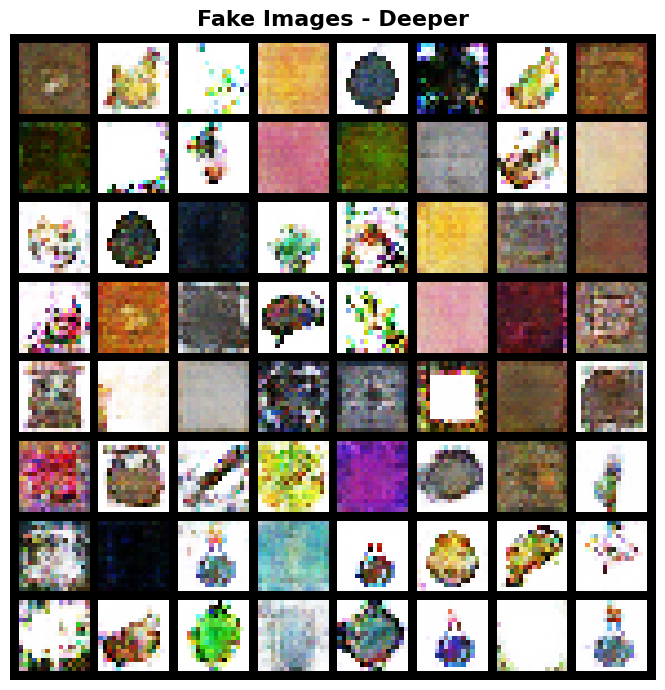

In [37]:
# Experiment 2: Deeper
print("\n🔬 EXPERIMENT 2: Deeper Network")
netG = DeeperGenerator(config['z_dim'], 32, 3).to(device)
netD = DeeperDiscriminator(3, 32).to(device)
netG.apply(weights_init)
netD.apply(weights_init)
arch_results['Deeper'] = train_gan(netG, netD, loader, config, config['num_epochs'], "Deeper")


🔬 EXPERIMENT 3: Wider Network

Training: Wider
Epoch [1/100] G: 1.7577 D: 1.1789
Epoch [2/100] G: 2.6183 D: 0.4869
Epoch [3/100] G: 2.7690 D: 0.4077
Epoch [4/100] G: 1.3855 D: 1.0737
Epoch [5/100] G: 1.1907 D: 1.1626
Epoch [6/100] G: 1.1640 D: 1.1510
Epoch [7/100] G: 1.0894 D: 1.1767
Epoch [8/100] G: 1.0047 D: 1.2414
Epoch [9/100] G: 1.0436 D: 1.0949
Epoch [10/100] G: 1.1660 D: 0.9895
Epoch [11/100] G: 1.2556 D: 0.8724
Epoch [12/100] G: 1.3200 D: 0.8604
Epoch [13/100] G: 1.3516 D: 0.9157
Epoch [14/100] G: 1.4099 D: 0.9723
Epoch [15/100] G: 1.3987 D: 1.0065
Epoch [16/100] G: 1.2916 D: 1.0013
Epoch [17/100] G: 1.2990 D: 1.0609
Epoch [18/100] G: 1.3181 D: 1.0553
Epoch [19/100] G: 1.2865 D: 1.0428
Epoch [20/100] G: 1.2271 D: 1.0877
Epoch [21/100] G: 1.2135 D: 1.0943
Epoch [22/100] G: 1.2556 D: 1.0339
Epoch [23/100] G: 1.2391 D: 1.0318
Epoch [24/100] G: 1.2530 D: 1.0067
Epoch [25/100] G: 1.2424 D: 0.9908
Epoch [26/100] G: 1.2665 D: 0.9459
Epoch [27/100] G: 1.3187 D: 0.9478
Epoch [28/100] G

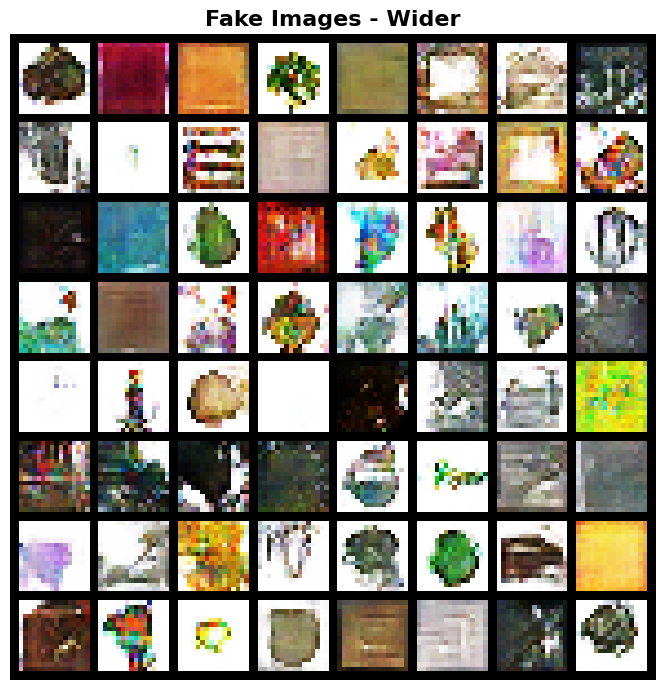

In [38]:
# Experiment 3: Wider
print("\n🔬 EXPERIMENT 3: Wider Network")
netG = WiderGenerator(config['z_dim'], 64, 3).to(device)
netD = WiderDiscriminator(3, 64).to(device)
netG.apply(weights_init)
netD.apply(weights_init)
arch_results['Wider'] = train_gan(netG, netD, loader, config, config['num_epochs'], "Wider")


🔬 EXPERIMENT 4: Residual Connections

Training: Residual
Epoch [1/100] G: 0.2751 D: 2.7492
Epoch [2/100] G: 0.5589 D: 2.0160
Epoch [3/100] G: 0.7348 D: 1.6502
Epoch [4/100] G: 0.7886 D: 1.5725
Epoch [5/100] G: 0.8560 D: 1.4645
Epoch [6/100] G: 0.8758 D: 1.3722
Epoch [7/100] G: 0.9963 D: 1.2768
Epoch [8/100] G: 0.9869 D: 1.2120
Epoch [9/100] G: 1.0221 D: 1.1452
Epoch [10/100] G: 1.0938 D: 1.0915
Epoch [11/100] G: 1.0626 D: 1.1290
Epoch [12/100] G: 1.0969 D: 1.0634
Epoch [13/100] G: 1.2478 D: 0.9762
Epoch [14/100] G: 1.2599 D: 0.9470
Epoch [15/100] G: 1.2279 D: 0.9373
Epoch [16/100] G: 1.3734 D: 0.9001
Epoch [17/100] G: 0.7853 D: 1.4760
Epoch [18/100] G: 0.6500 D: 1.6016
Epoch [19/100] G: 0.6697 D: 1.5074
Epoch [20/100] G: 0.6789 D: 1.4609
Epoch [21/100] G: 0.7074 D: 1.4481
Epoch [22/100] G: 0.6920 D: 1.4305
Epoch [23/100] G: 0.7010 D: 1.4271
Epoch [24/100] G: 0.6969 D: 1.4136
Epoch [25/100] G: 0.7307 D: 1.3943
Epoch [26/100] G: 0.6961 D: 1.4005
Epoch [27/100] G: 0.7009 D: 1.3962
Epoch 

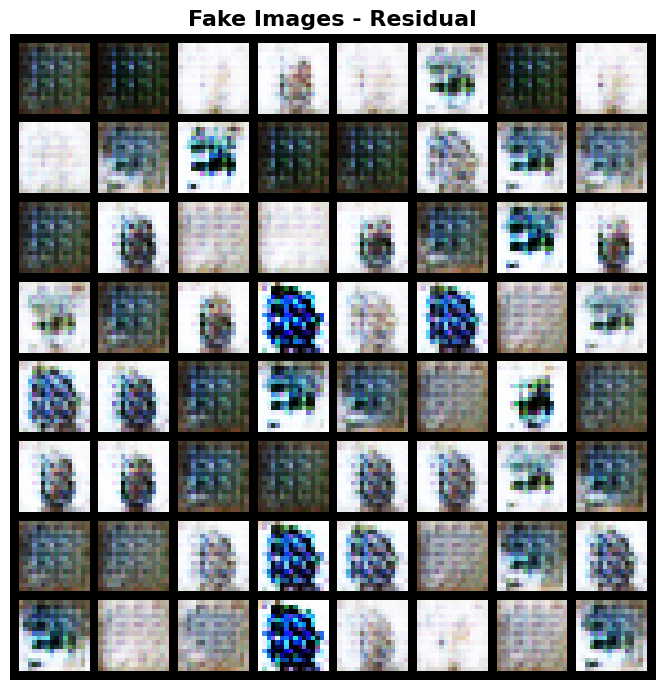

In [39]:
# Experiment 4: Residual
print("\n🔬 EXPERIMENT 4: Residual Connections")
netG = ResidualGenerator(config['z_dim'], 32, 3).to(device)
netD = BaselineDiscriminator(3, 32).to(device)
netG.apply(weights_init)
netD.apply(weights_init)
arch_results['Residual'] = train_gan(netG, netD, loader, config, config['num_epochs'], "Residual")


COMPONENT 1: ARCHITECTURE RESULTS SUMMARY


,Architecture,Avg G Loss,Avg D Loss,Final G Loss,Time (min)
0,Baseline,1.0387,1.1130,1.1642,5.05
1,Deeper,1.8920,0.7189,2.9454,6.40
2,Wider,1.6864,0.7725,1.7829,5.72
3,Residual,0.7569,1.3920,0.7119,5.47



GENERATED IMAGES COMPARISON


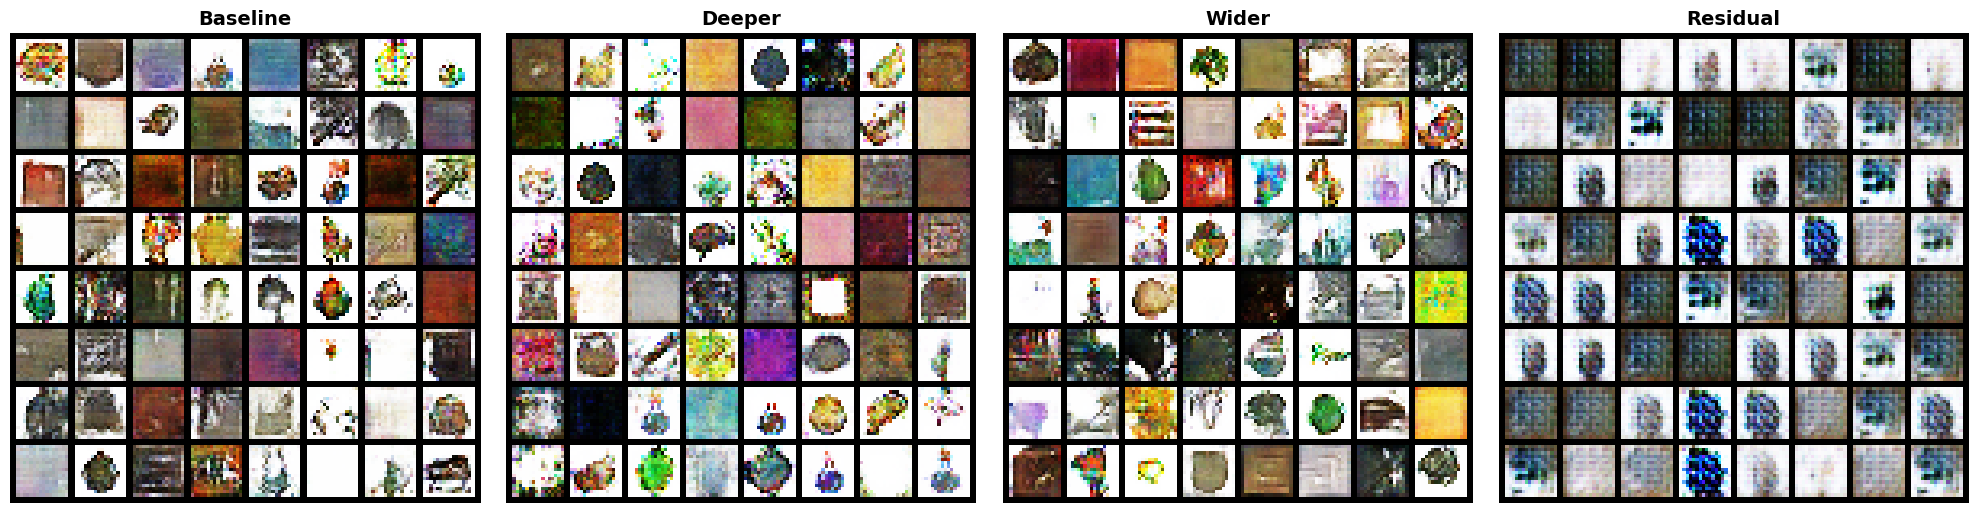

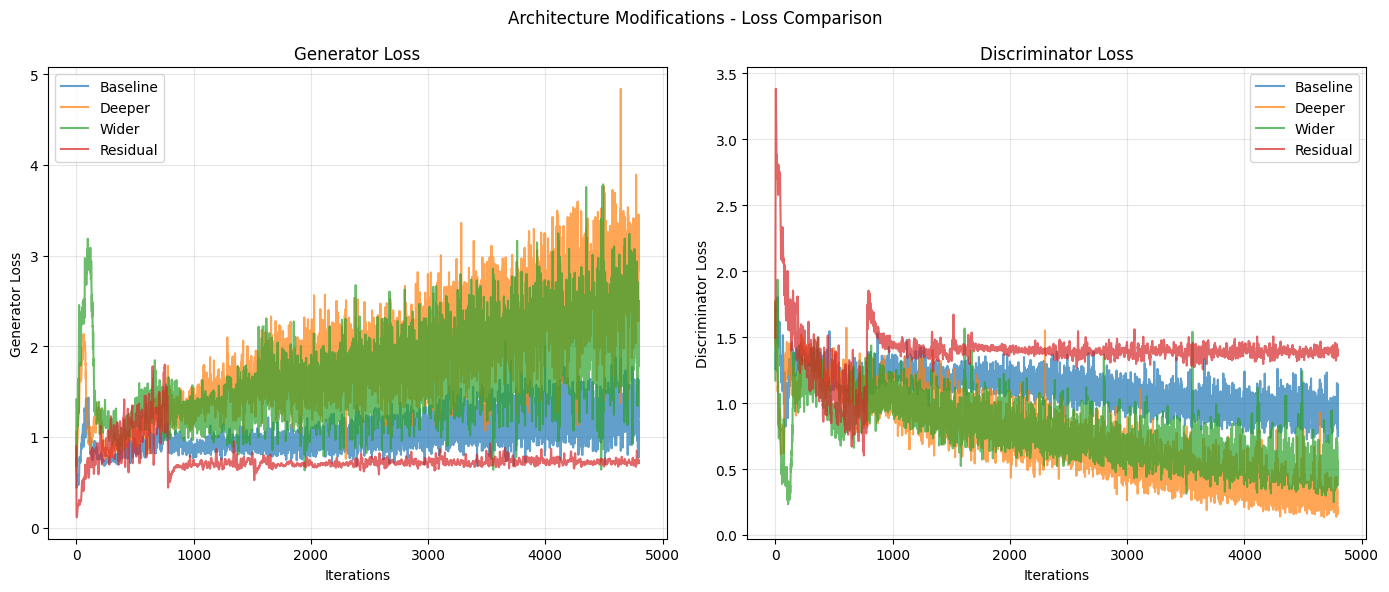

In [40]:
# Architecture Results
print("\n" + "="*70)
print("COMPONENT 1: ARCHITECTURE RESULTS SUMMARY")
print("="*70)

df_arch = pd.DataFrame([{
    'Architecture': name,
    'Avg G Loss': f"{np.mean(res['G_losses']):.4f}",
    'Avg D Loss': f"{np.mean(res['D_losses']):.4f}",
    'Final G Loss': f"{res['G_losses'][-1]:.4f}",
    'Time (min)': f"{res['time']/60:.2f}"
} for name, res in arch_results.items()])

display(df_arch)

# Show all generated images side by side
print("\n" + "="*70)
print("GENERATED IMAGES COMPARISON")
print("="*70)

n_arch = len(arch_results)
fig, axes = plt.subplots(1, n_arch, figsize=(5*n_arch, 5))

if n_arch == 1:
    axes = [axes]

for idx, (name, res) in enumerate(arch_results.items()):
    img = res['img_list'][-1]
    axes[idx].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axes[idx].set_title(name, fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Plot losses
plot_comparison(arch_results, "Architecture Modifications - Loss Comparison")